<h1><center>Лабораторна робота 5.</center></h1>
<h2><center>Логістична регресія й випадковий ліс в задачі кредитного скорингу</center></h2>

**Виконав:** Прізвище І.П.

**Варіант:** №__

<a class="anchor" id="lab-5"></a>

## Зміст 

- [5.1. Завантаження навчальних даних](#lab-5.1)
- [5.2. Бутстреп](#lab-5.2)  
- [5.3. Підбір параметрів для ансамблевих моделей](#lab-5.3)
- [5.4. Визначення впливу ознак](#lab-5.4)
- [5.5. Створення ансамблевих моделей](#lab-5.5)
- [5.6. Удосконалення ансамблевих моделей](#lab-5.6)

Головним завданням цієї лабораторної роботи є побудова моделі на основі машинного навчання (МН) для задачі кредитного скорингу.

<a class="anchor" id="lab-5.1"></a>

## <span style="color:blue; font-size:1.2em;">5.1. Завантаження навчальних даних</span>

[Повернутися до змісту](#lab-5)

Змінна, значення якої прогнозується, $Y$:

 - SeriousDlqin2yrs – стан невиплати людиною кредиту впроводж наступних 90 днів; можливі значення: 1 – клієнт оплачує кредит із запізненням або не виплачує взагалі, 0 – клієнт оплачує кредит вчасно. 

Незалежні ознаки, $X$:

 - age – вік позичальника кредитних коштів; тип – integer;
 - NumberOfTime30-59DaysPastDueNotWorse – кількість прострочених виплат інших кредитів більше 30-59 днів тому, але не більше впродовж останніх двох років; тип – integer;
 - DebtRatio – відношення щомісячного відрахування щодо заборгованості (кредити, аліменти тощо) до сукупного місячного доходу (percentage); тип – real;
 - MonthlyIncome – місячний дохід в доларах; тип – real;
 - NumberOfTimes90DaysLate – кількість прострочених виплат інших кредитів більше 90 днів; тип – integer;
 - NumberOfTime60-89DaysPastDueNotWorse – кількість прострочених виплат інших кредитів більш 60-89 днів, але не більше впродовж останніх двох років; тип – integer;
 - NumberOfDependents – кількість членів сім'ї позичальника; тип – integer.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Відключимо попередження Anaconda
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

In [2]:
# Задамо графіки у форматі .svg, щоби вони мали кращу чіткість
%config InlineBackend.figure_format = 'svg' 

# Підвищимо розмір графіків за замовчуванням
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 7, 5

Створимо функцію, яка буде замінювати NaN значення на медіану в кожному стовпчику таблиці:

In [3]:
def delete_nan(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

Завантажуємо дані для подальшого навчання:

In [4]:
credit_scoring_url = 'https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/refs/heads/main/02_assignments/ida_lab-05_logit-rf-credit-scoring/credit_scoring_sample.csv'

data = pd.read_csv(credit_scoring_url, sep =';')
data.head()

SeriousDlqin2yrs  age  NumberOfTime30-59DaysPastDueNotWorse    DebtRatio  \
0                 0   64                                     0     0.249908   
1                 0   58                                     0  3870.000000   
2                 0   41                                     0     0.456127   
3                 0   43                                     0     0.000190   
4                 1   49                                     0     0.271820   

   NumberOfTimes90DaysLate  NumberOfTime60-89DaysPastDueNotWorse  \
0                        0                                     0   
1                        0                                     0   
2                        0                                     0   
3                        0                                     0   
4                        0                                     0   

   MonthlyIncome  NumberOfDependents  
0         8158.0                 0.0  
1            NaN                 0.0  
2         6666.0                 0.0  
3        10500.0                 2.0  
4          400.0                 0.0

Розглянемо типи завантажених даних:

In [5]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Переглянемо розподіл класів у цільовій змінні:

Distribution of target


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

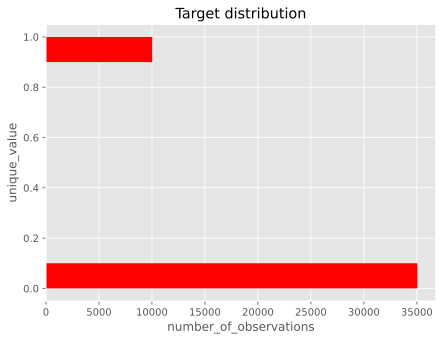

In [6]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

Далі виберемо назви всіх ознак з таблиці, крім прогнозованого.

In [7]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

Застосовуємо функцію, яка замінює всі NaN значення на медіанне значення відповідного стовпця.

In [8]:
table = delete_nan(data)

Розділяємо підготовлений набір даних на незалежні ознаки ($X$) та цільову ознаку ($y$).

In [9]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

<a class="anchor" id="lab-5.2"></a>

## <span style="color:blue; font-size:1.2em;">5.2. Бутстреп</span>

[Повернутися до змісту](#lab-5)

Спершу обрахуйте інтервальну оцінку середнього віку (age) для надійних клієнтів та тих клієнтів, що прострочили виплату кредиту з "впевненістю" >= 90% . Використайте приклад з лекції, поставте `np.random.seed (0)`, як це зроблено в огляді.

In [10]:
# Допоміжна функція для генерації підвибірок за допомогою бутстрепу
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

### <span style="color:red; font-size:1.5em;">Завдання 1</span>

---

**Варіант 1:** Обчисліть інтервальну оцінку медіанного доходу клієнтів віком понад 50 років. Для цього виберіть випадкову вибірку із 600 клієнтів із даними про дохід та вік. Використовуйте рівень значущості $\alpha = 0.05$. Це завдання допоможе вам зрозуміти, як можна використовувати статистичні методи для аналізу фінансових даних.

---

**Варіант 2:** Оцініть середню кількість прострочень виплат на 30–59 днів для клієнтів із борговим коефіцієнтом більше, ніж 1. Візьміть 500 записів із цього набору даних і використайте рівень значущості $\alpha = 0.02$. Це дасть змогу вам проаналізувати ризики затримок поміж клієнтів із високим співвідношенням борг/дохід.

---

**Варіант 3:** Обчисліть інтервальну оцінку для середнього доходу клієнтів, які мають більш як двоє утриманців. Оберіть 700 записів і використайте рівень значущості $\alpha = 0.07$. Оскільки кількість утриманців може суттєво впливати на платоспроможність, це завдання надасть важливі дані для аналізу групи таких клієнтів.

---

**Варіант 4:** Оцініть частку клієнтів, які мають більше, ніж три випадки прострочення виплат на 90 днів. Виберіть випадкову вибірку з 800 записів і проаналізуйте частку за рівнем значущості $\alpha = 0.03$. Це завдання допоможе визначити ймовірність наявності серйозних прострочень поміж клієнтів.

---

**Варіант 5:** Обчисліть інтервальну оцінку середнього віку клієнтів, що мають прострочення виплат на 60–89 днів. Для цього виберіть 1000 записів та обчисліть інтервал з $\alpha = 0.01$. Аналіз віку може допомогти виявити, чи є схильність до прострочень у старших або молодших клієнтів.

---

**Варіант 6:** Оцініть частку клієнтів із борговим коефіцієнтом більше, ніж 0.5, які не мають прострочених виплат. Виберіть вибірку із 600 клієнтів і використайте рівень значущості $\alpha = 0.11$. Цей аналіз покаже, наскільки борговий коефіцієнт впливає на фінансову дисципліну.

---

**Варіант 7:** Обчисліть інтервальну оцінку середнього доходу клієнтів, які мали прострочення виплат понад 90 днів. Виберіть 500 записів та розрахуйте інтервал довіри для доходу при $\alpha = 0.12$. Це завдання допоможе виявити, чи клієнти з високими доходами частіше потрапляють у затримки.

---

**Варіант 8:** Оцініть частку клієнтів із кількістю утриманців більш як двоє, які мають борговий коефіцієнт менше, ніж 1. Для цього використайте вибірку із 700 клієнтів та рівень значущості $\alpha = 0.09$. Дослідження фінансового навантаження на клієнтів із великою сім’єю може дати цінні висновки.

---

**Варіант 9:** Обчисліть інтервальну оцінку для середнього віку клієнтів, які мають більше, ніж три прострочені кредити. Візьміть вибірку з 800 записів та рівень значущості $\alpha = 0.08$. Цей аналіз допоможе виявити вік клієнтів, які частіше потрапляють у боргові пастки.

---

**Варіант 10:** Оцініть середній борговий коефіцієнт клієнтів, які мають утриманців, але не мають прострочених виплат. Виберіть 1000 клієнтів і використайте рівень значущості $\alpha = 0.06$. Цей аналіз покаже фінансову відповідальність клієнтів із сім’ями, що не затримують виплати.

---

**Варіант 11:** Обчисліть частку клієнтів, які мали прострочення виплат на 30–59 днів, але жодного разу не прострочували більше, ніж 90 днів. Виберіть 600 записів та використайте рівень значущості $\alpha = 0.14$. Цей аналіз дасть змогу зрозуміти поведінку клієнтів, що затримують виплати, але не допускають серйозних затримок.

---

**Варіант 12:** Оцініть інтервальну оцінку середнього доходу клієнтів віком більше, ніж 40 років, які не мають прострочених виплат. Виберіть 500 клієнтів і використайте рівень значущості $\alpha = 0.02$. Цей аналіз допоможе виявити зв’язок між віком та доходами відповідальних клієнтів.

---

**Варіант 13:** Обчисліть частку клієнтів із місячним доходом більше, ніж 5000, які мають прострочення виплат на 60–89 днів. Для цього оберіть 700 записів та використайте рівень значущості $\alpha = 0.04$. Це допоможе зрозуміти, як дохід впливає на ймовірність прострочень.

---

**Варіант 14:** Оцініть інтервальну оцінку для середнього віку клієнтів, які мають борговий коефіцієнт більше, ніж 2. Виберіть 800 записів та використайте рівень значущості $\alpha = 0.16$. Це завдання дасть змогу вивчити залежність між віком і високими борговими навантаженнями.

---

**Варіант 15:** Обчисліть середню кількість прострочених виплат на 30–59 днів для клієнтів із доходом більше, ніж 7000. Виберіть 1000 записів та використайте рівень значущості $\alpha = 0.05$. Це завдання дасть змогу проаналізувати фінансову поведінку заможних клієнтів щодо виплат.

---

**Варіант 16:** Оцініть частку клієнтів, які мають більш як два прострочення на 90 днів та не мають утриманців. Оберіть 600 записів та використайте рівень значущості $\alpha = 0.1$. Це завдання допоможе зрозуміти, чи наявність утриманців впливає на платіжну дисципліну.

---

**Варіант 17:** Обчисліть інтервальну оцінку середнього доходу клієнтів, які мають більше, ніж три утриманці. Для цього виберіть 700 записів та використайте рівень значущості $\alpha = 0.11$. Це завдання покаже, як кількість утриманців впливає на дохід клієнтів.

---

**Варіант 18:** Оцініть частку клієнтів із доходом більше, ніж 8000, які мали прострочення виплат на 60–89 днів. Виберіть 500 клієнтів та використайте рівень значущості $\alpha = 0.05$. Це завдання допоможе дослідити залежність між рівнем доходу та ймовірністю прострочень.

---

**Варіант 19:** Обчисліть інтервальну оцінку для середнього боргового коефіцієнта клієнтів із простроченнями більше, ніж 90 днів. Виберіть 800 записів та використайте рівень значущості $\alpha = 0.01$. Це дасть змогу вивчити, як боргове навантаження клієнтів корелює з тривалими простроченнями.

---

**Варіант 20:** Оцініть інтервальну оцінку середнього віку клієнтів, які мають більше, ніж одне прострочення виплат на 30–59 днів та борговий коефіцієнт менше, ніж 1. Виберіть випадкову вибірку із 750 записів і використайте рівень значущості $\alpha = 0.05$. Це завдання покаже залежність між віком клієнтів та їхньою платіжною дисципліною за невеликого боргового навантаження.

<a class="anchor" id="lab-5.3"></a>

## <span style="color:blue; font-size:1.2em;">5.3. Підбір параметрів для ансамблевих моделей</span>

[Повернутися до змісту](#lab-5)

Однією з важливих метрик якості моделі є значення площі під [ROC-кривої](https://uk.wikipedia.org/wiki/ROC-%D0%BA%D1%80%D0%B8%D0%B2%D0%B0) (AUC). Значення ROC-AUC лежить від 0 до 1. Чим ближче значення метрики ROC-AUC до 1, тим якісніше відбувається класифікація моделлю.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Використовуємо модуль [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) для побудови логістичної регресії. Через незбалансованість класів в цільовій функції додаємо параметр балансування. Також додамо параметр `random_state=5` для відтворюваності результатів.

In [12]:
lr = LogisticRegression(random_state=5, class_weight= 'balanced')

Тепер спробуємо підібрати найкращий коефіцієнт регуляризації (коефіцієнт C в логістичній регресії) для моделі логістичної регрессії. Найкраще значення параметра С забезпечить нам оптимальність моделі, яка буде добре прогнозувати значення цільової функції і водночас не буде перенавчатися. Інші параметри залишаємо за замовчуванням.

In [13]:
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

Щоби підібрати коефіцієнт регуляризації переглянемо значення `ROC-AUC` на Stratified крос-валідації з 5 фолдів для кожного можливого значення коефіцієнта регуляризації за допомогою класу [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html).

In [14]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

Далі для розв'язку наступного завдання використайте [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) з метрикою `ROC-AUC` за параметром C.

### <span style="color:red; font-size:1.5em;">Завдання 2</span>

---

**Варіант 1:** Побудуйте модель беггінгу дерев рішень для поданої задачі кредитного скорингу. Знайдіть оптимальне значення параметра `max_depth` за допомогою `GridSearchCV`. Перевірте різні варіанти глибини дерева, щоб знайти оптимальну кількість вузлів, що дасть змогу підвищити точність моделі. Порівняйте результати побудованого беггінгу дерев рішень з базовою моделлю логістичної регресії за метрикою `ROC-AUC`.

*Технічна примітка:* Під час побудови моделі необхідно використати параметр `base_estimator=DecisionTreeClassifier()` у методі `BaggingClassifier`, а для пошуку оптимального значення `max_depth` – викликати клас `GridSearchCV` із набором параметрів для глибини дерева.

---

**Варіант 2:** Побудуйте модель беггінгу дерев рішень для задачі кредитного скорингу та знайдіть оптимальне значення параметра `n_estimators` за допомогою `GridSearchCV`. Виберіть кілька варіантів кількості дерев у моделі, щоб знайти оптимальну кількість для найкращої точності прогнозу. Порівняйте результати побудованого беггінгу дерев рішень з базовою моделлю логістичної регресії за метрикою `ROC-AUC`.

*Технічна примітка:* Для пошуку оптимальної кількості дерев скористайтеся параметром `n_estimators` у класі `BaggingClassifier`. Клас `GridSearchCV` дасть змогу підібрати оптимальне значення цього параметра через перебір варіантів, використовуючи набір даних для крос-валідації.

---

**Варіант 3:** Побудуйте модель беггінгу дерев рішень для кредитного скорингу, визначте оптимальне значення параметра `min_samples_split` за допомогою `GridSearchCV`. Розгляньте декілька варіантів мінімальної кількості зразків, необхідних для поділу вузла дерева, щоб мінімізувати перенавчання моделі. Оптимізація цього параметра покращить точність прогнозу, особливо на глибоких деревах. Порівняйте результати побудованого беггінгу дерев рішень з базовою моделлю логістичної регресії за метрикою `ROC-AUC`.

*Технічна примітка:* Параметр `min_samples_split` визначає мінімальну кількість зразків, які потрібні для поділу вузла дерева в моделі. Його оптимізацію можна виконати за допомогою `GridSearchCV`, перебираючи кілька значень цього параметра для покращення стабільності моделі.

---

**Варіант 4:** Побудуйте модель беггінгу дерев рішень для кредитного скорингу та знайдіть оптимальне значення параметра `max_leaf_nodes` за допомогою `RandomizedSearchCV`. Вибір оптимальної кількості листових вузлів допоможе контролювати розмір дерева і зменшить ймовірність перенавчання моделі. Порівняйте результати побудованого беггінгу дерев рішень з базовою моделлю логістичної регресії за метрикою `ROC-AUC`.

*Технічна примітка:* Параметр `max_leaf_nodes` дає можливість обмежити кількість кінцевих вузлів у кожному дереві. Для оптимізації використайте клас `RandomizedSearchCV`, що скоротить час пошуку порівняно з `GridSearchCV`, перевіряючи випадкові значення параметра на різних ітераціях.

---

**Варіант 5:** Побудуйте модель беггінгу дерев рішень для задачі кредитного скорингу та знайдіть оптимальне значення параметра `min_samples_leaf` за допомогою `GridSearchCV`. Це дасть змогу зменшити перенавчання, регулюючи мінімальну кількість зразків, які залишаються в листовому вузлі дерева, що насамкінець впливатиме на обчислювальну ефективність моделі. Порівняйте результати побудованого беггінгу дерев рішень з базовою моделлю логістичної регресії за метрикою `ROC-AUC`.

*Технічна примітка:* Параметр `min_samples_leaf` визначає мінімальну кількість зразків, що повинні бути в кожному листі. Для його налаштування використайте `GridSearchCV`, додаючи різні значення цього параметра в сітку пошуку, щоб знизити ймовірність перенавчання.

---

**Варіант 6:** Побудуйте модель беггінгу дерев рішень для задачі кредитного скорингу та знайдіть оптимальне значення параметра `bootstrap_features` за допомогою `RandomizedSearchCV`. Оптимізуйте цей параметр, щоб контролювати кількість ознак, які випадково вибираються для кожного дерева. Порівняйте результати побудованого беггінгу дерев рішень з базовою моделлю логістичної регресії за метрикою `ROC-AUC`.

*Технічна примітка:* Параметр `bootstrap_features` визначає, чи будуть випадково вибиратися ознаки для кожного дерева. Для пошуку оптимального значення використайте `RandomizedSearchCV`, що дає можливість досліджувати широкий діапазон можливих варіантів.

---

**Варіант 7:** Побудуйте модель беггінгу дерев рішень для поданої задачі кредитного скорингу. Визначте оптимальне значення параметра `max_samples` за допомогою `GridSearchCV`, що контролює кількість зразків, які використовуються для навчання кожного дерева. Це допоможе підвищити стабільність та точність моделі. Порівняйте результати побудованого беггінгу дерев рішень з базовою моделлю логістичної регресії за метрикою `ROC-AUC`.

*Технічна примітка:* Параметр `max_samples` визначає частку зразків, які використовуються для навчання кожного дерева в моделі. Для його налаштування використайте клас `GridSearchCV`, перевіряючи різні значення цього параметра на навчальних даних.

---

**Варіант 8:** Побудуйте модель беггінгу дерев рішень для задачі кредитного скорингу та знайдіть оптимальне значення параметра `oob_score` за допомогою `GridSearchCV`. Використання позавибіркових зразків (OOB) допоможе оцінити результативність моделі без необхідності додаткової валідації. Порівняйте результати побудованого беггінгу дерев рішень з базовою моделлю логістичної регресії за метрикою `ROC-AUC`.

*Технічна примітка:* Параметр `oob_score` дає можливість використовувати позавибіркові зразки для оцінювання продуктивності моделі. Увімкніть цей параметр у класі `BaggingClassifier` і налаштуйте його за допомогою `GridSearchCV` для підвищення точності оцінки.

---

**Варіант 9:** Побудуйте модель беггінгу дерев рішень для кредитного скорингу та знайдіть оптимальне значення параметра `bootstrap` за допомогою `GridSearchCV`. Визначте, чи варто використовувати повторну вибірку з навчальних даних для кожного дерева, щоби покращити узагальнення моделі. Порівняйте результати побудованого беггінгу дерев рішень з базовою моделлю логістичної регресії за метрикою `ROC-AUC`.

*Технічна примітка:* Параметр `bootstrap` визначає, чи використовуються всі навчальні зразки або лише їхня підмножина. Пошук оптимального значення цього параметра можна виконати за допомогою `GridSearchCV`, додаючи в сітку варіанти `True` та `False`.

---

**Варіант 10:** Побудуйте модель беггінгу дерев рішень для поданої задачі кредитного скорингу. Оптимізуйте параметр `warm_start` за допомогою `GridSearchCV`, що дає можливість оновлювати модель під час додавання нових дерев без перенавчання всієї моделі. Порівняйте результати побудованого беггінгу дерев рішень з базовою моделлю логістичної регресії за метрикою `ROC-AUC`.

*Технічна примітка:* Параметр `warm_start` дає можливість оновлювати модель, додаючи нові дерева без повторного навчання всієї моделі. Використайте `GridSearchCV` для перевірки цього параметра і його впливу на загальну результативність моделі.

---

**Варіант 11:** Побудуйте модель беггінгу дерев рішень для задачі кредитного скорингу та знайдіть оптимальне значення параметра `random_state` за допомогою `GridSearchCV`. Це дасть змогу контролювати випадковість у виборі зразків і підвищить відтворюваність результатів моделі. Порівняйте результати побудованого беггінгу дерев рішень з базовою моделлю логістичної регресії за метрикою `ROC-AUC`.

*Технічна примітка:* Параметр `random_state` контролює випадковість у виборі зразків для кожного дерева. Налаштування цього параметра за допомогою `GridSearchCV` дасть змогу забезпечити стабільність і відтворюваність результатів.

---

**Варіант 12:** Побудуйте модель беггінгу дерев рішень для задачі кредитного скорингу та знайдіть оптимальне значення параметра `max_features` за допомогою `GridSearchCV`. Оптимізація цього параметра дасть змогу контролювати кількість ознак, які використовуються для кожного дерева, що може вплинути на результативність і узагальнення моделі. Порівняйте результати побудованого беггінгу дерев рішень з базовою моделлю логістичної регресії за метрикою `ROC-AUC`.

*Технічна примітка:* Параметр `max_features` визначає кількість ознак, які використовуються для створення кожного дерева. Використання `GridSearchCV` допоможе підібрати оптимальне значення цього параметра для покращення якості моделі.

---

**Варіант 13:** Побудуйте модель беггінгу дерев рішень для кредитного скорингу. Використовуючи `GridSearchCV`, знайдіть оптимальне значення параметра `criterion`, який визначає клас для вимірювання якості розподілу на кожному кроці дерева. Це дасть змогу зробити модель більш точною та стабільною. Порівняйте результати побудованого беггінгу дерев рішень з базовою моделлю логістичної регресії за метрикою `ROC-AUC`.

*Технічна примітка:* Параметр `criterion` вказує, яку метрику використовувати для оцінювання якості розподілу: `gini` або `entropy`. Оптимізація цього параметра через `GridSearchCV` допоможе обрати найкращий критерій для вашої задачі.

---

**Варіант 14:** Побудуйте модель беггінгу дерев рішень для задачі кредитного скорингу та знайдіть оптимальне значення параметра `max_samples` за допомогою `RandomizedSearchCV`. Оптимізуйте вибір кількості зразків для кожного дерева, щоби покращити здатність моделі узагальнювати на нові дані. Порівняйте результати побудованого беггінгу дерев рішень з базовою моделлю логістичної регресії за метрикою `ROC-AUC`.

*Технічна примітка:* Параметр `max_samples` дає можливість визначити частку даних, яку кожне дерево використовує для навчання. Для пошуку оптимальних значень скористайтеся класом `RandomizedSearchCV`, яка скоротить кількість обчислень, перевіряючи випадкові значення. Порівняйте результати побудованого беггінгу дерев рішень з базовою моделлю логістичної регресії за метрикою `ROC-AUC`.

---

**Варіант 15:** Побудуйте модель беггінгу дерев рішень для поданої задачі кредитного скорингу. Використайте `GridSearchCV` для пошуку оптимального значення параметра `min_weight_fraction_leaf`, який визначає мінімальну частку загальної ваги зразків у кожному листі. Це дасть змогу зменшити можливість перенавчання на незначущих зразках. Порівняйте результати побудованого беггінгу дерев рішень з базовою моделлю логістичної регресії за метрикою `ROC-AUC`.

*Технічна примітка:* Параметр `min_weight_fraction_leaf` вказує мінімальну частку ваги зразків у листі дерева, що допомагає уникнути перенавчання на малозначущих даних. Використання `GridSearchCV` дасть змогу знайти найкраще значення для цього параметра.

---

**Варіант 16:** Побудуйте модель беггінгу дерев рішень для задачі кредитного скорингу та знайдіть оптимальне значення параметра `max_leaf_nodes` за допомогою `GridSearchCV`. Цей параметр дає можливість обмежити кількість листових вузлів, що впливає на глибину дерева і швидкість обчислень. Порівняйте результати побудованого беггінгу дерев рішень з базовою моделлю логістичної регресії за метрикою `ROC-AUC`.

*Технічна примітка:* Параметр `max_leaf_nodes` обмежує кількість листів у кожному дереві. Використайте `GridSearchCV` для визначення оптимальної кількості вузлів, що дасть змогу покращити результативність моделі та її узагальнювальну здатність.

---

**Варіант 17:** Побудуйте модель беггінгу дерев рішень для поданої задачі кредитного скорингу. Використайте `GridSearchCV` для пошуку оптимального значення параметра `min_impurity_decrease`, який визначає мінімальне зменшення зашумлення, що необхідне для поділу вузла. Порівняйте результати побудованого беггінгу дерев рішень з базовою моделлю логістичної регресії за метрикою `ROC-AUC`.

*Технічна примітка:* Параметр `min_impurity_decrease` використовується для контролю мінімального зменшення варіабельності, що необхідне для поділу вузла. Це дасть змогу знизити перенавчання моделі, а для оптимізації значень варто скористатися класом `GridSearchCV`.

---

**Варіант 18:** Побудуйте модель беггінгу дерев рішень для задачі кредитного скорингу та знайдіть оптимальне значення параметра `min_samples_leaf` за допомогою `RandomizedSearchCV`. Це допоможе обмежити кількість зразків, необхідних для створення листових вузлів, що покращить ефективність моделі на малих даних. Порівняйте результати побудованого беггінгу дерев рішень з базовою моделлю логістичної регресії за метрикою `ROC-AUC`.

*Технічна примітка:* Параметр `min_samples_leaf` визначає мінімальну кількість зразків, що мають бути присутні в кожному листі дерева. Для пошуку оптимального значення Використайте `RandomizedSearchCV`, щоби перевірити різні варіанти та знизити можливість перенавчання.

---

**Варіант 19:** Побудуйте модель беггінгу дерев рішень для поданої задачі кредитного скорингу та оптимізуйте параметр `splitter`, який відповідає за метод поділу вузлів дерева на основі найкращого критерію. Визначте, який метод поділу – «best» чи «random» – найкраще підходить для вашої задачі, використовуючи `GridSearchCV`. Порівняйте результати побудованого беггінгу дерев рішень з базовою моделлю логістичної регресії за метрикою `ROC-AUC`.

*Технічна примітка:* Параметр `splitter` у `DecisionTreeClassifier` визначає, як здійснюється поділ вузлів дерева: на основі найкращого поділу чи випадково. Використайте `GridSearchCV` для перевірки різних варіантів, щоб обрати найкращий підхід для вашої моделі.

---

**Варіант 20:** Побудуйте модель беггінгу дерев рішень для задачі кредитного скорингу та знайдіть оптимальне значення параметра `max_depth` за допомогою `RandomizedSearchCV`. Глибина дерева впливає на точність моделі, тому оптимізація цього параметра дасть змогу знайти баланс між недонавчанням та перенавчання. Порівняйте результати побудованого беггінгу дерев рішень з базовою моделлю логістичної регресії за метрикою `ROC-AUC`.

*Технічна примітка:* Параметр `max_depth` контролює максимальну глибину кожного дерева в моделі. Для його оптимізації Використайте клас `RandomizedSearchCV`, що дасть змогу зменшити час пошуку, перевіряючи випадкові варіанти глибини дерева на навчальних даних.

<a class="anchor" id="lab-5.4"></a>

## <span style="color:blue; font-size:1.2em;">5.4. Визначення впливу ознак</span>

[Повернутися до змісту](#lab-5)

У цьому завданні ми попрацюємо з важливістю ознак. Пам'ятаємо, що важливість ознаки визначається **абсолютним значенням її коефіцієнта**. Крім того, потрібно заздалегідь нормалізувати всі ознаки, щоб їх правильно порівняти.

In [15]:
from sklearn.preprocessing import StandardScaler

lr = LogisticRegression(C=0.001,random_state=5, class_weight='balanced')
scal = StandardScaler()
lr.fit(scal.fit_transform(X), y)

LogisticRegression(C=0.001, class_weight='balanced', random_state=5)

Обрахуємо важливість ознак:

In [16]:
pd.DataFrame({'feat': independent_columns_names,
              'coef': lr.coef_.flatten().tolist()}).sort_values(by='coef', ascending=False)

feat      coef
1  NumberOfTime30-59DaysPastDueNotWorse  0.723427
3               NumberOfTimes90DaysLate  0.516788
4  NumberOfTime60-89DaysPastDueNotWorse  0.193558
6                    NumberOfDependents  0.101443
2                             DebtRatio -0.024096
5                         MonthlyIncome -0.163146
0                                   age -0.416702

### <span style="color:red; font-size:1.5em;">Завдання 3</span>

---

**Варіант 1:** Обрахуйте вплив ознаки `NumberOfDependents` на ймовірність прострочення платежу впродовж 2 років за допомогою функції softmax. Для цього закодуйте та обчисліть функцію [softmax](https://en.wikipedia.org/wiki/Softmax_function).

---

**Варіант 2:** Обрахуйте частку впливу чинника `MonthlyIncome` на ймовірність прострочення платежу впродовж 2 років за допомогою функції softmax. Для цього закодуйте та обчисліть функцію [softmax](https://en.wikipedia.org/wiki/Softmax_function).

---

**Варіант 3:** У скільки разів збільшиться ймовірність прострочення платежу, якщо кількість випадків прострочення виплат на 30–59 днів збільшиться на 1 у випадку незмінності інших чинників?

---

**Варіант 4:** Оцініть вплив збільшення віку на 5 років на ймовірність прострочення платежу за умови незмінності інших чинників.

---

**Варіант 5:** Оцініть вплив ознаки `NumberOfTime30–59DaysPastDueNotWorse` на ймовірність прострочення платежу за допомогою функції softmax. Для цього закодуйте та обчисліть функцію [softmax](https://en.wikipedia.org/wiki/Softmax_function).

---

**Варіант 6:** Оцініть вплив збільшення кількості утриманців на 1 на ймовірність прострочення платежу впродовж 2 років.

---

**Варіант 7:** Оцініть, як збільшення боргового навантаження (DebtRatio) на 0.1 впливає на ймовірність прострочення платежу за допомогою функції softmax.

---

**Варіант 8:** Обрахуйте частку впливу чинника `NumberOfTimes90DaysLate` на ймовірність прострочення платежу впродовж 2 років за допомогою функції softmax. Для цього закодуйте та обчисліть функцію [softmax](https://en.wikipedia.org/wiki/Softmax_function).

---

**Варіант 9:** Оцініть вплив зменшення місячного доходу на 20 % на ймовірність прострочення платежу. Використайте функцію [softmax](https://en.wikipedia.org/wiki/Softmax_function) для оцінювання впливу. Змінна: `MonthlyIncome`.

---

**Варіант 10:** Оцініть вплив ознаки `DebtRatio` на ймовірність прострочення платежу впродовж 2 років за допомогою функції [softmax](https://en.wikipedia.org/wiki/Softmax_function). Змініть `DebtRatio` та обчисліть функцію softmax.

---

**Варіант 11:** Обрахуйте, як впливає збільшення кількості випадків прострочення платежу на 60–89 днів на 1 на ймовірність прострочення платежу впродовж 2 років. Використайте функцію [softmax](https://en.wikipedia.org/wiki/Softmax_function). Змінна: `NumberOfTime60–89DaysPastDueNotWorse`.

---

**Варіант 12:** Оцініть, як вплине збільшення віку позичальника на 10 років на ймовірність прострочення платежу за умови незмінності інших чинників. Обчисліть за допомогою [softmax](https://en.wikipedia.org/wiki/Softmax_function). Змінна: `age`.

---

**Варіант 13:** Оцініть вплив збільшення кількості кредитів, що прострочені на 30–59 днів, на ймовірність дефолту, використовуючи функцію [softmax](https://en.wikipedia.org/wiki/Softmax_function). Змінна: `NumberOfTime30–59DaysPastDueNotWorse`.

---

**Варіант 14:** Оцініть вплив збільшення кількості утриманців на ймовірність прострочення платежу впродовж 2 років, використовуючи функцію [softmax](https://en.wikipedia.org/wiki/Softmax_function). Змінна: `NumberOfDependents`.

---

**Варіант 15:** Оцініть, як збільшення місячного доходу на 15 % впливає на ймовірність вчасної виплати кредиту. Використайте [softmax](https://en.wikipedia.org/wiki/Softmax_function) для оцінювання впливу. Змінна: `MonthlyIncome`.

---

**Варіант 16:** Обчисліть вплив зменшення кількості утриманців на ймовірність прострочення платежу. Для обчислення використайте функцію [softmax](https://en.wikipedia.org/wiki/Softmax_function). Змінна: `NumberOfDependents`.

---

**Варіант 17:** Оцініть вплив збільшення показника `DebtRatio` на 0.05 на ймовірність невиплати кредиту за допомогою [softmax](https://en.wikipedia.org/wiki/Softmax_function).

---

**Варіант 18:** Обчисліть частку впливу кількості випадків прострочення платежу на 90 днів на ймовірність прострочення платежу впродовж 2 років, використовуючи функцію [softmax](https://en.wikipedia.org/wiki/Softmax_function). Змінна: `NumberOfTimes90DaysLate`.

---

**Варіант 19:** Оцініть вплив збільшення віку на 3 роки на ймовірність своєчасної виплати кредиту, використовуючи функцію [softmax](https://en.wikipedia.org/wiki/Softmax_function). Змінна: `age`.

---

**Варіант 20:** Оцініть вплив збільшення кількості утриманців позичальника на ймовірність отримання кредиту. Використайте функцію [softmax](https://en.wikipedia.org/wiki/Softmax_function) для оцінювання впливу. Змінна: `NumberOfDependents`.

In [17]:
# Ваш код тут

***Примітка 1:*** Приклад реалізації функції softmax можете підчитати [тут](https://machinelearningmastery.com/softmax-activation-function-with-python/).

***Примітка 2:***

Формула, за якою обраховують у скільки разів збільшаться шанси при підвищенні знчення ознаки:

$$ \large \exp^{\beta\delta}, $$

де

$ \beta $ – значення ознаки; $ \delta $ – на скільки робимо приріст.



<a class="anchor" id="lab-5.5"></a>

## <span style="color:blue; font-size:1.2em;">5.5. Створення ансамблевих моделей</span>

[Повернутися до змісту](#lab-5)

### <span style="color:red; font-size:1.5em;">Завдання 4</span>

---

**Для всіх варіантів:**

Для розв'язку наступного завдання потрібно реалізувати [Stratified k-fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) валідацію. Ініціалізація валідації має зберігатися в у змінній `skf` з попередніх завдань.

---

**Варіант 1:** Побудуйте модель випадкового лісу, використовуючи підбір гіперпараметрів: кількість дерев (`n_estimators`), максимальна глибина дерева (`max_depth`), та мінімальна кількість зразків для поділу вузла (`min_samples_split`). Задайте простір пошуку: `n_estimators` від 100 до 200 з кроком 50, `max_depth` від 10 до 20 з кроком 5, та `min_samples_split` від 2 до 4 з кроком 1.

---

**Варіант 2:** Побудуйте модель випадкового лісу, експериментуючи з гіперпараметрами: максимальна кількість ознак для розгляду за поділу дерева (`max_features`), мінімальна кількість зразків на листок (`min_samples_leaf`), та кількість дерев у лісі (`n_estimators`). Простір пошуку: `max_features` від 0.2 до 0.5 з кроком 0.1, `min_samples_leaf` від 1 до 3 з кроком 1, та `n_estimators` від 100 до 200 з кроком 50.

---

**Варіант 3:** Побудуйте модель випадкового лісу, варіюючи гіперпараметри: критерій розбиття вузлів (`criterion`), кількість дерев (`n_estimators`), та мінімальна кількість зразків для поділу вузла (`min_samples_split`). Простір пошуку: для `criterion` – {`gini`, `entropy`}, `n_estimators` від 100 до 300 з кроком 100, `min_samples_split` від 2 до 5 з кроком 1.

---

**Варіант 4:** Створіть модель випадкового лісу з налаштуванням кількості дерев у лісі (`n_estimators`), мінімальної кількості зразків для листка (`min_samples_leaf`), та мінімальної кількості зразків для поділу вузла (`min_samples_split`). Простір пошуку: `n_estimators` від 50 до 150 з кроком 50, `min_samples_leaf` від 1 до 3 з кроком 1, та `min_samples_split` від 2 до 4 з кроком 1.

---

**Варіант 5:** Побудуйте модель випадкового лісу, підбираючи кількість дерев (`n_estimators`), глибину дерева (`max_depth`), та кількість ознак для розгляду за кожного поділу дерева (`max_features`). Простір пошуку: `n_estimators` від 150 до 250 з кроком 50, `max_depth` від 5 до 15 з кроком 5, та `max_features` від 0.3 до 0.5 з кроком 0.1.

---

**Варіант 6:** Побудуйте модель випадкового лісу, використовуючи варіації гіперпараметрів: критерій розбиття вузлів (`criterion`), кількість дерев у лісі (`n_estimators`), та кількість ознак для розгляду за поділу дерева (`max_features`). Простір пошуку: `criterion` – {`gini`, `entropy`}, `n_estimators` від 50 до 200 з кроком 50, та `max_features` від 0.3 до 0.6 з кроком 0.1.

---

**Варіант 7:** Реалізуйте модель випадкового лісу для задачі кредитного скорингу з підбором таких гіперпараметрів: кількість дерев (`n_estimators`), максимальна глибина дерева (`max_depth`), та мінімальна кількість зразків для листка (`min_samples_leaf`). Простір пошуку: `n_estimators` від 200 до 300 з кроком 50, `max_depth` від 10 до 20 з кроком 5, та `min_samples_leaf` від 1 до 3 з кроком 1.

---

**Варіант 8:** Побудуйте модель випадкового лісу, змінюючи кількість дерев (`n_estimators`), мінімальну кількість зразків для поділу вузла (`min_samples_split`), та кількість ознак для розгляду за кожного поділу дерева (`max_features`). Простір пошуку: `n_estimators` від 100 до 250 з кроком 50, `min_samples_split` від 2 до 5 з кроком 1, та `max_features` від 0.2 до 0.6 з кроком 0.1.

---

**Варіант 9:** Побудуйте модель випадкового лісу для задачі кредитного скорингу, змінюючи кількість дерев (`n_estimators`), максимальну кількість ознак для розгляду за поділу дерева (`max_features`), та критерій розбиття вузлів (`criterion`). Простір пошуку: `n_estimators` від 150 до 300 з кроком 50, `max_features` від 0.2 до 0.5 з кроком 0.1, та `criterion` – {`gini`, `entropy`}.

---

**Варіант 10:** Побудуйте модель випадкового лісу, використовуючи такі гіперпараметри: кількість дерев у лісі (`n_estimators`), максимальна глибина дерева (`max_depth`), та мінімальна кількість зразків для листка (`min_samples_leaf`). Простір пошуку: `n_estimators` від 50 до 150 з кроком 50, `max_depth` від 3 до 15 з кроком 3, та `min_samples_leaf` від 1 до 3 з кроком 1.

---

**Варіант 11:** Створіть модель випадкового лісу, використовуючи підбір гіперпараметрів: максимальна кількість ознак для розгляду за поділу дерева (`max_features`), мінімальна кількість зразків для листка (`min_samples_leaf`), та кількість дерев у лісі (`n_estimators`). Простір пошуку: `max_features` від 0.3 до 0.6 з кроком 0.1, `min_samples_leaf` від 2 до 8 з кроком 2, та `n_estimators` від 100 до 200 з кроком 50.

---

**Варіант 12:** Побудуйте модель випадкового лісу для задачі кредитного скорингу, експериментуючи з гіперпараметрами: кількість дерев (`n_estimators`), мінімальна кількість зразків для поділу вузла (`min_samples_split`), та максимальна глибина дерева (`max_depth`). Простір пошуку: `n_estimators` від 100 до 250 з кроком 50, `min_samples_split` від 2 до 6 з кроком 1, та `max_depth` від 5 до 20 з кроком 5.

---

**Варіант 13:** Побудуйте модель випадкового лісу, змінюючи гіперпараметри: кількість дерев (`n_estimators`), кількість ознак для розгляду за поділу дерева (`max_features`), та критерій розбиття вузлів (`criterion`). Простір пошуку: `n_estimators` від 50 до 200 з кроком 50, `max_features` від 0.2 до 0.5 з кроком 0.1, та `criterion` – {`gini`, `entropy`}.

---

**Варіант 14:** Створіть модель випадкового лісу для задачі кредитного скорингу, використовуючи підбір гіперпараметрів: кількість дерев у лісі (`n_estimators`), мінімальна кількість зразків для листка (`min_samples_leaf`), та мінімальна кількість зразків для поділу вузла (`min_samples_split`). Простір пошуку: `n_estimators` від 100 до 250 з кроком 50, `min_samples_leaf` від 3 до 7 з кроком 1, та `min_samples_split` від 2 до 4 з кроком 1.

---

**Варіант 15:** Побудуйте модель випадкового лісу, змінюючи кількість дерев (`n_estimators`), максимальну кількість ознак для розгляду за поділу дерева (`max_features`), та критерій розбиття вузлів (`criterion`). Простір пошуку: `n_estimators` від 50 до 150 з кроком 50, `max_features` від 0.2 до 0.5 з кроком 0.1, та `criterion` – {`gini`, `entropy`}.

---

**Варіант 16:** Побудуйте модель випадкового лісу для задачі кредитного скорингу, експериментуючи з гіперпараметрами: кількість дерев у лісі (`n_estimators`), мінімальна кількість зразків для поділу вузла (`min_samples_split`), та мінімальна кількість зразків для листка (`min_samples_leaf`). Простір пошуку: `n_estimators` від 50 до 150 з кроком 50, `min_samples_split` від 2 до 5 з кроком 1, та `min_samples_leaf` від 1 до 3 з кроком 1.

---

**Варіант 17:** Побудуйте модель випадкового лісу, використовуючи підбір гіперпараметрів: максимальна глибина дерева (`max_depth`), кількість дерев (`n_estimators`), та кількість ознак для розгляду за поділу дерева (`max_features`). Простір пошуку: `max_depth` від 10 до 20 з кроком 5, `n_estimators` від 100 до 200 з кроком 50, та `max_features` від 0.3 до 0.5 з кроком 0.1.

---

**Варіант 18:** Реалізуйте модель випадкового лісу для задачі кредитного скорингу, варіюючи такі гіперпараметри: критерій розбиття вузлів (`criterion`), кількість дерев у лісі (`n_estimators`), та кількість ознак для розгляду за поділу дерева (`max_features`). Простір пошуку: `criterion` – {`gini`, `entropy`}, `n_estimators` від 50 до 150 з кроком 50, та `max_features` від 0.2 до 0.4 з кроком 0.1.

---

**Варіант 19:** Побудуйте модель випадкового лісу, використовуючи підбір гіперпараметрів: кількість дерев у лісі (`n_estimators`), мінімальна кількість зразків для поділу вузла (`min_samples_split`), та мінімальна кількість зразків для листка (`min_samples_leaf`). Простір пошуку: `n_estimators` від 100 до 200 з кроком 50, `min_samples_split` від 2 до 5, та `min_samples_leaf` від 1 до 3 з кроком 1.

---

**Варіант 20:** Створіть модель випадкового лісу для задачі кредитного скорингу, експериментуючи з гіперпараметрами: кількість дерев (`n_estimators`), максимальна глибина дерева (`max_depth`), та кількість ознак для розгляду за кожного поділу дерева (`max_features`). Простір пошуку: `n_estimators` від 50 до 150 з кроком 50, `max_depth` від 4 до 10 з кроком 2, та `max_features` від 0.2 до 0.4 з кроком 0.1.

<a class="anchor" id="lab-5.6"></a>

## <span style="color:blue; font-size:1.2em;">5.6. Удосконалення ансамблевих моделей</span>

[Повернутися до змісту](#lab-5)

Наступне завдання полягатиме у навчанні та удосконаленні ансамблевих моделей.

### <span style="color:red; font-size:1.5em;">Завдання 5</span>

---

**Варіант 1:** Виконайте покращення результативності моделі випадкового лісу, налаштувавши параметр `max_depth`. Визначте, яке значення глибини дерев сприяє найкращій результативності та забезпечує досягнення частки правильних відповідей (accuracy) >=90 % за валідаційним набором даних. Після налаштування цього параметра повторно оцініть модель за основними статистичними метриками, як от precision, recall та F1-score.

*Технічна примітка:* Використовуйте бібліотеку `scikit-learn` та її клас `RandomForestClassifier`. За допомогою класу `GridSearchCV` налаштуйте параметр `max_depth`, експериментуючи з різними значеннями (наприклад, від 5 до 20), й оцініть, як це впливає на результативність.

---

**Варіант 2:** Використайте метод ансамблевого навчання, додавши до побудованої моделі випадкового лісу засіб «бустингу». Створіть модель, що комбінує переваги бустингу та випадкових лісів, щоб досягти частки правильних відповідей >=90 % за валідаційним набором даних. Проаналізуйте, як така комбінація впливає на результативність моделі та чи вдалося підвищити частку правильних відповідей у порівнянні з попередньою версією моделі.

*Технічна примітка:* Використовуйте бібліотеку `scikit-learn` та клас `AdaBoostClassifier` у поєднанні з `RandomForestClassifier`. Налаштуйте параметри бустингу через клас `GridSearchCV`, особливо звернувши увагу на кількість ітерацій бустингу (`n_estimators`).

---

**Варіант 3:** Виконайте покращення результативності моделі випадкового лісу, застосувавши оброблення пустих комірок через засіб заповнення даних. Використовуйте метод середніх значень або метод $knn$ для заповнення відсутніх значень у наборі даних перед навчанням моделі. Перевірте, чи покращиться частка правильних відповідей моделі до >=90 %.

*Технічна примітка:* Використовуйте класи `SimpleImputer` або `KNNImputer` з бібліотеки `sklearn.impute`. Спочатку заповніть пропущені дані, а потім навчайте модель `RandomForestClassifier`, порівнюючи результати з базовою моделлю.

---

**Варіант 4:** Виконайте покращення результативності моделі випадкового лісу, застосувавши метод крос-валідації з 10 фолдами, щоб зменшити ймовірність перенавчання та досягти стабільного результату із часткою правильних відповідей >=90 %. Проаналізуйте результати кожного фолду та зробіть висновки щодо загальної результативності моделі.

*Технічна примітка:* Використовуйте метод `cross_val_score` з бібліотеки `scikit-learn` для виконання крос-валідації. Налаштуйте параметри моделі, зокрема `n_estimators` та `max_depth`, під час кожного фолду.

---

**Варіант 5:** Виконайте покращення результативності моделі випадкового лісу за допомогою алгоритму `RandomizedSearchCV`. Це дасть змогу вам знаходити найкращі гіперпараметри моделі, зокрема кількість дерев у лісі та мінімальну кількість зразків для розбиття вузлів, щоби досягнути частку правильних відповідей >=90 %.

*Технічна примітка:* Використовуйте клас `RandomizedSearchCV` з бібліотеки `scikit-learn`, щоб автоматизувати пошук оптимальних значень гіперпараметрів. Особливо зверніть увагу на параметри `n_estimators`, `max_depth` та `min_samples_split`.

---

**Варіант 6:** Додайте до моделі випадкового лісу регуляризацію, застосувавши метод випадкового відсіву ознак (`feature bagging`). Це дасть змогу моделі бути менш схильною до перенавчання та досягти стабільної частки правильних відповідей >=90 %. Після цього проаналізуйте вплив регуляризації на результативність моделі.

*Технічна примітка:* Використовуйте параметр `max_features` у класі `RandomForestClassifier` з бібліотеки `scikit-learn`, щоб відсівати частину ознак на кожному етапі побудови дерев.

---

**Варіант 7:** Застосуйте до моделі випадкового лісу засіб оброблення дисбалансу класів за допомогою параметра `class_weight='balanced'`. Це дасть можливість компенсувати нерівномірний розподіл класів і можливо досягти частки правильних відповідей >=90 % за валідаційним набором даних.

*Технічна примітка:* У класі `RandomForestClassifier` використовуйте параметр `class_weight='balanced'`, щоб автоматично зважувати класи залежно від їхньої частоти у вибірці.

---

**Варіант 8:** Виконайте покращення результативності моделі випадкового лісу, додавши до неї оброблення кореляційних ознак. Використайте метод видалення ознак із високою кореляцією перед навчанням моделі. Це може допомогти моделі уникнути проблеми мультиколінеарності та можливо досягти частки правильних відповідей >=90 %.

*Технічна примітка:* Використайте бібліотеку `pandas` для обчислення кореляційної матриці. Видаліть ознаки, кореляція між якими перевищує 0.9, і повторно навчайте модель `RandomForestClassifier`.

---

**Варіант 9:** Застосуйте засіб бустингу на основі випадкового лісу, використавши `GradientBoostingClassifier`. Мета – покращити результативність моделі та досягти частки правильних відповідей >=90 % за валідаційним набором даних. Порівняйте результати з базовою моделлю випадкового лісу, оцінюючи зміни в метриках precision, recall та F1-score.

*Технічна примітка:* Використовуйте клас `GradientBoostingClassifier` з бібліотеки `scikit-learn` для реалізації бустингу поверх моделі випадкового лісу.

---

**Варіант 10:** Виконайте покращення результативності моделі випадкового лісу, налаштувавши параметр `min_samples_leaf`. Це дасть змогу контролювати мінімальну кількість зразків, необхідних для створення нового листка дерева. Експериментуйте з різними значеннями цього параметра та визначте, яке налаштування дасть змогу досягти частки правильних відповідей >=90 %.

*Технічна примітка:* Використовуйте клас `RandomForestClassifier` з бібліотеки `scikit-learn`, налаштувавши параметр `min_samples_leaf` через клас `GridSearchCV` або `RandomizedSearchCV`.

---

**Варіант 11:** Виконайте покращення результативності моделі випадкового лісу, використавши метод зваженого голосування. Створіть ансамбль моделей, де ваги для кожної моделі будуть визначені на основі їхньої частки правильних відповідей за валідаційним набором даних. Перевірте, чи вдалося досягти частки правильних відповідей >=90 %.

*Технічна примітка:* Використовуйте клас `VotingClassifier` з бібліотеки `scikit-learn` для реалізації зваженого голосування. Задайте різні моделі як базові класифікатори (наприклад, випадковий ліс та логістична регресія).

---

**Варіант 12:** Використайте ансамблевий підхід через побудову кількох моделей випадкових лісів із різними налаштуваннями гіперпараметрів і об’єднання їхніх результатів для досягнення частки правильних відповідей >=90 %. Застосуйте метод голосування для об’єднання результатів кожної моделі.

*Технічна примітка:* Використовуйте клас `VotingClassifier` з бібліотеки `scikit-learn` для поєднання кількох моделей `RandomForestClassifier` з різними значеннями гіперпараметрів через `GridSearchCV`.

---

**Варіант 13:** Виконайте покращення результативності моделі випадкового лісу, використовуючи метод підвищення ваг для важливих ознак (`feature importance weighting`). Призначте вищі ваги ознакам, що мають більшу значущість, і проаналізуйте, чи вдалося підвищити частку правильних відповідей моделі до >=90 %.

*Технічна примітка:* Використовуйте метод `feature_importances_` у класі `RandomForestClassifier` для визначення ваг ознак. Потім модифікуйте модель, налаштувавши ваги ознак залежно від їхньої важливості.

---

**Варіант 14:** Виконайте покращення результативності моделі випадкового лісу, додавши підхід до пошуку оптимальних параметрів через `Bayesian Optimization`. Потенційно, це дасть змогу знайти найкращі параметри моделі для досягнення частки правильних відповідей >=90 %.

*Технічна примітка:* Використовуйте бібліотеку `bayesian-optimization` або `scikit-optimize`, щоб виконати `Bayesian Optimization` для пошуку найкращих гіперпараметрів моделі випадкового лісу.

---

**Варіант 15:** Додайте до моделі випадкового лісу можливість автоматичного вибору найбільш важливих ознак, використовуючи метод `Recursive Feature Elimination` (RFE). Це дасть змогу автоматично відсіяти менш значущі ознаки та потенційно досягти частки правильних відповідей >=90 %.

*Технічна примітка:* Використовуйте клас `RFE` з бібліотеки `scikit-learn` для вибору найважливіших ознак, що впливають на результативність моделі `RandomForestClassifier`.

---

**Варіант 16:** Виконайте покращення результативності моделі випадкового лісу через засіб TPE (`Tree-structured Parzen Estimator`), яка дає можливість шукати оптимальні гіперпараметри краще, ніж стандартний `GridSearchCV`, та досягти частки правильних відповідей >=90 %.

*Технічна примітка:* Використовуйте бібліотеку `hyperopt` для реалізації алгоритму TPE для налаштування гіперпараметрів моделі випадкового лісу.

---

**Варіант 17:** Виконайте покращення результативності моделі випадкового лісу, налаштувавши параметр `n_estimators`, що визначає кількість дерев у лісі. Експериментуйте з більшими значеннями цього параметра для досягнення частки правильних відповідей >=90 %. Збільшення кількості дерев може покращити частку правильних відповідей моделі, але також збільшить час обчислення.

*Технічна примітка:* Використовуйте клас `RandomForestClassifier` з бібліотеки `scikit-learn` і клас `GridSearchCV` для підбору оптимального значення `n_estimators`, тестуючи різні значення, наприклад, від 100 до 1000.

---

**Варіант 18:** Використайте засіб усереднення передбачень (bagging), де ви побудуєте кілька випадкових лісів із різними підвибірками даних та ознак, а потім об’єднаєте їхні результати для досягнення частки правильних відповідей >=90 %. Це дасть змогу зменшити варіативність моделі та підвищити її стабільність.

*Технічна примітка:* Використовуйте клас `BaggingClassifier` з бібліотеки `scikit-learn`, поєднуючи кілька моделей `RandomForestClassifier` і оцінюючи результат через метод усереднення передбачень.

---

**Варіант 19:** Застосуйте метод випадкових вибірок (subsampling) під час навчання моделі випадкового лісу. Вибірка меншої кількості даних для кожного дерева може зменшити ймовірність перенавчання та покращити узагальнювальну здатність моделі, що сприятиме досягненню частки правильних відповідей >=90 %.

*Технічна примітка:* Використовуйте параметр `bootstrap=True` у класі `RandomForestClassifier`, щоб увімкнути випадкові підвибірки даних для кожного дерева. Налаштуйте також параметр `max_samples`, щоб контролювати розмір вибірки.

---

**Варіант 20:** Виконайте покращення результативності моделі випадкового лісу, налаштувавши параметр `max_features`. Визначте, яку кількість ознак варто враховувати під час пошуку найкращого розділення, щоби отримати частку правильних відповідей (accuracy) >=90 % за валідаційним набором даних. Після налаштування цього параметра повторно оцініть модель за основними статистичними метриками, як от precison, recall та F1-score.

*Технічна примітка:* Використовуйте бібліотеку `scikit-learn` та її клас `RandomForestClassifier`. За допомогою класу `RandomizedSearchCV` налаштуйте параметр `max_features`, експериментуючи з різними значеннями, й оцініть, як це впливає на результативність.